# Data Exploration

## Data preparation

In [2]:
import gcsfs
import json

gcs_file_system = gcsfs.GCSFileSystem(project="capstone")
gcs_json_path = "gs://radiology-data/report_CT.json"
with gcs_file_system.open(gcs_json_path) as f:
    data = json.load(f)

In [2]:
len(data)

246824

In [3]:
# Access specific information in the data
report_id = data['Report_6']['report_id']
modality = data['Report_6']['modality']
clinical_information = data['Report_6']['clinical_information']['clinical_information']
findings_group = data['Report_6']['findings_group']['findings']
impression_group = data['Report_6']['impression_group']['impression']

# Print the extracted information
print(f"Report ID: {report_id}")
print(f"Modality: {modality}")
print(f"Clinical Information: {clinical_information}")
print(f"Findings: {findings_group}")
print(f"Impression: {impression_group}")

Report ID: 6
Modality: CT
Clinical Information: locally recurrent oral tongue squamous cell carcinoma referred here for consideration of clinical trial participation.
Findings: There are post-treatment findings in the neck related to partial right glossectomy with mandibulectomy, flap reconstruction, and neck dissection. There is an infiltrative heterogeneous mass in the left masticator, parapharyngeal, and pharyngeal mucosal spaces, with associated left mandible, posterior maxillary sinus wall, and central skull base erosion and extension into the left middle cranial fossa. There is partial opacification of the bilateral maxillary sinuses and complete left tympanomastoid opacification. There is a cluster of prominent left level 6 lymph nodes. The thyroid gland appears unremarkable. The orbits are unremarkable.
Impression: Postoperative findings with evidence of recurrent tumor in the left masticator, parapharyngeal, and pharyngeal mucosal spaces, with associated left mandible, posteri

## Converting data to DataFrame

In [3]:
length_findings = []
length_clinical_info = []
length_impression = []
full_report = []
for key, value in data.items():
    report = dict()
    report_id = value['report_id']
    try:
        clinical_information = value['clinical_information']['clinical_information']
    except KeyError:
        clinical_information = "" 
    findings_group = value['findings_group']['findings']
    impression_group = value['impression_group']['impression']
    full_report.append(report)
    report['report_id'] = report_id
    report['clinical_information'] = clinical_information
    report['findings'] = findings_group
    report['impression'] = impression_group
    length_clinical_info.append(len(clinical_information))
    length_findings.append(len(findings_group))
    length_impression.append(len(impression_group))

In [13]:
import pandas as pd
CT_report = pd.DataFrame(full_report)

In [14]:
CT_report.head()

,report_id,clinical_information,findings,impression
0,6,locally recurrent oral tongue squamous cell ca...,There are post-treatment findings in the neck ...,Postoperative findings with evidence of recurr...
1,7,64 years old male with history of left humerus...,". Scattered pulmonary micronodules, some which...",No evidence of metastatic disease.
2,13,"female, 57 years old, with subarachnoid hemorr...",A large coil mass is redemonstrated in the reg...,Redemonstration of a large coil mass situated ...
3,14,"male, 66 years old, status post subdural hemor...",Findings are redemonstrated compatible with su...,No significant change in the size of bilateral...
4,15,empty.,The ventricles and sulci are within normal lim...,No acute intracranial hemorrhage.


In [33]:
import numpy as np
sum(np.array(length_clinical_info) == 0)

473

In [47]:
length_clinical_info = np.array(length_clinical_info)
length_findings = np.array(length_findings)
length_impression = np.array(length_impression)

## Basic Statistics of the Texts

In [51]:
# Calculate the total number of rows
total_rows = len(CT_report)
print(f"Number of total rows is {total_rows}")
print("\n")
# Calculate the number of unique values in each column
unique_values = CT_report.nunique()
print("Unique values per column")
print(unique_values)
print("\n")
# Get the most frequent values in each column
most_frequent_values = CT_report.mode().iloc[0]
print(most_frequent_values)
print("\n")
# Calculate the average text length for each column
average_length_CI = length_clinical_info.mean()
average_length_F = length_findings.mean()
average_length_I = length_impression.mean()
print(f"The average length of Clinical Information is {average_length_CI}")
print(f"The average length of Findings is {average_length_F}")
print(f"The average length of Impression is {average_length_I}")
print("\n")
# Number of Zero Information
print(f"Number of unavailable Clinical Information is {sum(length_clinical_info == 0)}")
print(f"Number of unavailable Findings is {sum(length_findings == 0)}")
print(f"Number of unavailable Impression is {sum(length_impression == 0)}")

Number of total rows is 246824


Unique values per column
report_id               246824
clinical_information    204153
findings                246544
impression              224889
dtype: int64


report_id                                                6
clinical_information                                empty.
findings                                             empty
impression              No evidence of metastatic disease.
Name: 0, dtype: object


The average length of Clinical Information is 84.73523239231193
The average length of Findings is 989.3876486889443
The average length of Impression is 227.9504181116909


Number of unavailable Clinical Information is 473
Number of unavailable Findings is 0
Number of unavailable Impression is 0


### Text PreProcessing

In [26]:
#!pip install text-preprocessing
from text_preprocessing import preprocess_text

In [31]:
CT_report_pre = CT_report.copy()

In [32]:
CT_report_pre['findings'] = CT_report_pre['findings'].str.lower()
CT_report_pre['findings'] = CT_report_pre['findings'].str.replace('[^\w\s]', '')

CT_report_pre['clinical_information'] = CT_report_pre['clinical_information'].str.lower()
CT_report_pre['clinical_information'] = CT_report_pre['clinical_information'].str.replace('[^\w\s]', '')

CT_report_pre['impression'] = CT_report_pre['impression'].str.lower()
CT_report_pre['impression'] = CT_report_pre['impression'].str.replace('[^\w\s]', '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Define stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Preprocess text in a specific column
df['findings_preprocessed'] = df['findings'].apply(lambda x: ' '.join([stemmer.stem(token) for token in word_tokenize(x.lower()) if token.isalpha() and token not in stop_words]))


### Most common word

In [33]:
from collections import Counter

# Combine all text columns into a single list of words
all_words = ' '.join(CT_report_pre['findings'] + ' ' + CT_report_pre['clinical_information'] + ' ' + CT_report_pre['impression']).split()

word_counts = Counter(all_words)

# Print the most common words and their frequencies
most_common_words = word_counts.most_common(10)
print(most_common_words)

[('the', 2256228), ('no', 1735073), ('of', 1438642), ('noted', 1149360), ('significant', 1122714), ('abnormality', 1068115), ('is', 997324), ('and', 993447), ('in', 778464), ('with', 624915)]


In [4]:
import nltk

In [34]:
#nltk.download('all')
stopwords = nltk.corpus.stopwords.words('english')
most_100 =word_counts.most_common(100)
n=0
for word, count in most_100:
    if n == 10:
        break
    if word.lower() not in stopwords:
        print(word, count)
        n+=1

noted 1149360
significant 1122714
abnormality 1068115
right 588316
left 508180
small 241166
evidence 230609
x 210352
lobe 199338
unchanged 192949


In [43]:
from collections import Counter

# Combine all text columns into a single list of words
all_words_findings = ' '.join(CT_report_pre['findings']).split() 
all_words_clinical_information =' '.join(CT_report_pre['clinical_information']).split()
all_words_impression =' '.join(CT_report_pre['impression']).split()

word_counts_f = Counter(all_words_findings)
word_counts_ci = Counter(all_words_clinical_information)
word_counts_i = Counter(all_words_impression)

In [44]:
most_100_f =word_counts_f.most_common(100)
most_100_ci =word_counts_ci.most_common(100)
most_100_i =word_counts_i.most_common(100)

n=0
for word, count in most_100_f:
    if n == 10:
        break
    if word.lower() not in stopwords:
        print(word, count)
        n+=1

noted 1141456
significant 1098073
abnormality 1049191
right 443711
left 385461
x 204598
small 189604
cm 184709
normal 173940
unchanged 172688


In [45]:
n=0
for word, count in most_100_ci:
    if n == 10:
        break
    if word.lower() not in stopwords:
        print(word, count)
        n+=1

old 105478
years 104505
history 95363
female 61653
evaluate 58663
status 58406
male 57478
cancer 52775
post 50859
pain 41863


In [46]:
n=0
for word, count in most_100_i:
    if n == 10:
        break
    if word.lower() not in stopwords:
        print(word, count)
        n+=1

right 115895
left 100712
evidence 86280
disease 61633
acute 51748
stable 47597
small 47352
interval 44258
findings 43900
lobe 43606


### Text Length Analysis

In [66]:
length_texts = pd.DataFrame(data = [length_clinical_info, length_findings, length_impression], index = ["clinical info", "findings", "impression"])

In [67]:
length_texts = length_texts.T

In [68]:
length_texts.describe()

,clinical info,findings,impression
count,246824.000000,246824.000000,246824.000000
mean,84.735232,989.387649,227.950418
std,59.149413,487.006414,170.193797
min,0.000000,4.000000,4.000000
25%,46.000000,636.000000,104.000000
50%,77.000000,902.000000,188.000000
75%,113.000000,1251.000000,307.000000
max,1100.000000,8365.000000,2388.000000


<AxesSubplot:ylabel='Frequency'>

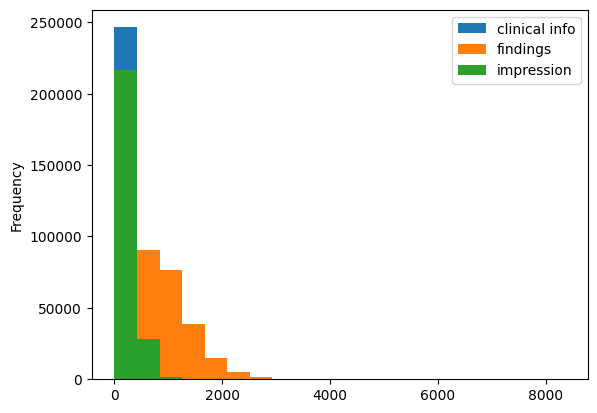

In [69]:
length_texts.plot(kind='hist', bins=20)

### N-gram Analysis

In [35]:
from nltk import ngrams

# Generate n-grams for each text column
n = 2  # Example: 2-grams
ngrams_findings = list(ngrams(all_words, n))

# Count the occurrence of each n-gram
ngram_counts = Counter(ngrams_findings)

# Print the most common n-grams and their frequencies
most_common_ngrams = ngram_counts.most_common(10)
print(most_common_ngrams)

[(('no', 'significant'), 1083579), (('significant', 'abnormality'), 1036223), (('abnormality', 'noted'), 1029943), (('noted', 'no'), 667690), (('of', 'the'), 518586), (('in', 'the'), 438858), (('there', 'is'), 327831), (('the', 'right'), 262233), (('the', 'left'), 232059), (('evidence', 'of'), 216526)]


In [36]:
most_100 =ngram_counts.most_common(100)
n=0
for word, count in most_100:
    if n == 10:
        break
    if word[0] not in stopwords and word[1] not in stopwords:
        print(word, count)
        n+=1

('significant', 'abnormality') 1036223
('abnormality', 'noted') 1029943
('years', 'old') 101885
('lymph', 'nodes') 96109
('status', 'post') 94286
('soft', 'tissue') 67799
('lymph', 'node') 67286
('lower', 'lobe') 65523
('air', 'cells') 61563
('upper', 'lobe') 59876


In [56]:
from nltk import ngrams

# Generate n-grams for each text column
n = 2  # Example: 2-grams
ngrams_findings = list(ngrams(all_words_findings, n))

# Count the occurrence of each n-gram
ngram_counts = Counter(ngrams_findings)

# Print the most common n-grams and their frequencies
most_common_ngrams = ngram_counts.most_common(10)
print(most_common_ngrams)

[(('no', 'significant'), 1070632), (('significant', 'abnormality'), 1034519), (('abnormality', 'noted'), 1029361), (('noted', 'no'), 683019), (('of', 'the'), 418055), (('in', 'the'), 349149), (('there', 'is'), 305352), (('the', 'right'), 214970), (('the', 'left'), 191246), (('evidence', 'of'), 137001)]


In [57]:
most_100 =ngram_counts.most_common(100)
n=0
for word, count in most_100:
    if n == 10:
        break
    if word[0] not in stopwords and word[1] not in stopwords:
        print(word, count)
        n+=1

('significant', 'abnormality') 1034519
('abnormality', 'noted') 1029361
('lymph', 'nodes') 82177
('air', 'cells') 58869
('lymph', 'node') 58649
('soft', 'tissue') 51226
('mastoid', 'air') 50745
('limits', 'sensitivity') 50492
('contrast', 'material') 50464
('enteric', 'contrast') 49716


In [58]:
from nltk import ngrams

# Generate n-grams for each text column
n = 2  # Example: 2-grams
ngrams_findings = list(ngrams(all_words_clinical_information, n))

# Count the occurrence of each n-gram
ngram_counts = Counter(ngrams_findings)

# Print the most common n-grams and their frequencies
most_common_ngrams = ngram_counts.most_common(10)
print(most_common_ngrams)

[(('years', 'old'), 101872), (('history', 'of'), 63015), (('status', 'post'), 48629), (('female', 'with'), 43354), (('old', 'male'), 43152), (('evaluate', 'for'), 42869), (('old', 'female'), 41708), (('male', 'with'), 40181), (('with', 'history'), 29996), (('abdominal', 'pain'), 16005)]


In [59]:
most_100 =ngram_counts.most_common(100)
n=0
for word, count in most_100:
    if n == 10:
        break
    if word[0] not in stopwords and word[1] not in stopwords:
        print(word, count)
        n+=1

('years', 'old') 101872
('status', 'post') 48629
('old', 'male') 43152
('old', 'female') 41708
('abdominal', 'pain') 16005
('cancer', 'status') 13044
('yearold', 'female') 12789
('lung', 'cancer') 10700
('pulmonary', 'embolism') 7546
('yearold', 'male') 7293


In [60]:
from nltk import ngrams

# Generate n-grams for each text column
n = 2  # Example: 2-grams
ngrams_findings = list(ngrams(all_words_impression, n))

# Count the occurrence of each n-gram
ngram_counts = Counter(ngrams_findings)

# Print the most common n-grams and their frequencies
most_common_ngrams = ngram_counts.most_common(10)
print(most_common_ngrams)

[(('of', 'the'), 95201), (('in', 'the'), 86516), (('evidence', 'of'), 78120), (('no', 'evidence'), 62374), (('the', 'right'), 45347), (('the', 'left'), 39071), (('metastatic', 'disease'), 27061), (('to', 'the'), 24437), (('there', 'is'), 22341), (('acute', 'intracranial'), 22273)]


In [61]:
most_100 =ngram_counts.most_common(100)
n=0
for word, count in most_100:
    if n == 10:
        break
    if word[0] not in stopwords and word[1] not in stopwords:
        print(word, count)
        n+=1

('metastatic', 'disease') 27061
('acute', 'intracranial') 22273
('soft', 'tissue') 16094
('lower', 'lobe') 15639
('intracranial', 'hemorrhage') 14452
('upper', 'lobe') 14059
('lymph', 'nodes') 13286
('may', 'represent') 12971
('right', 'lower') 10746
('mass', 'effect') 10074


### Topic Modelling

In [ ]:
from gensim import models
from gensim.corpora import Dictionary

# Create a dictionary and corpus of text
texts = [CT_report_pre['findings'], CT_report_pre['background'], CT_report_pre['impression']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Perform topic modeling using LDA
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary)

# Print the most significant words for each topic
for idx, topic in lda_model.print_topics():
    print(f"Topic {idx+1}: {topic}")


### Text Clustering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Combine all text columns into a single column
df['combined_text'] = df['findings'] + ' ' + df['background'] + ' ' + df['impression']

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['combined_text'])

# Perform K-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Get cluster labels for each sample
cluster_labels = kmeans.labels_

# Print the cluster labels
print(cluster_labels)


### Text Visualization

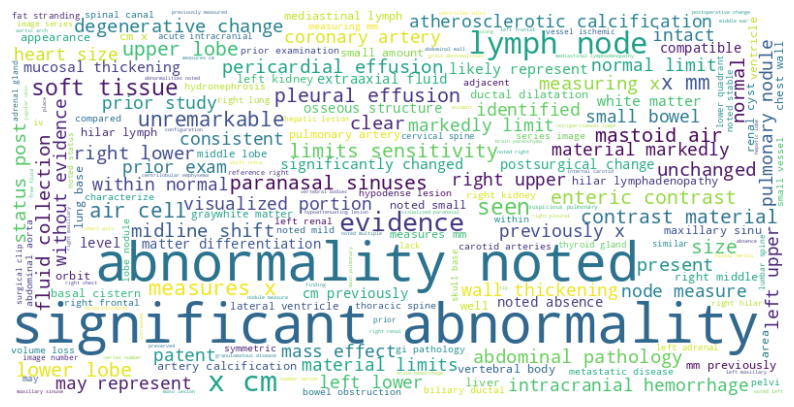

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text columns into a single string
all_text = ' '.join(CT_report_pre['findings'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


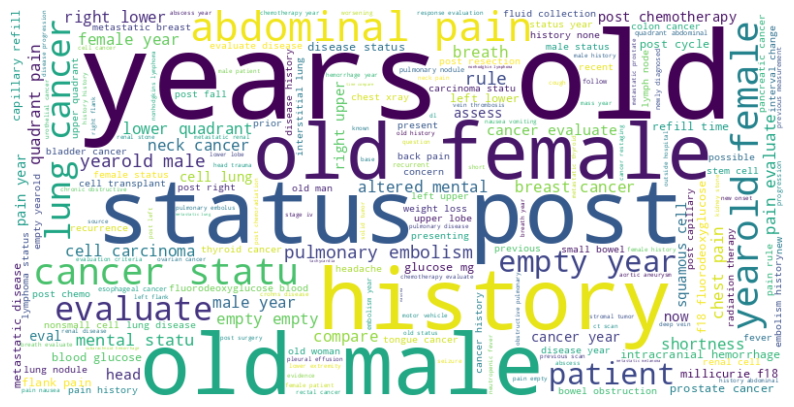

In [62]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text columns into a single string
all_text = ' '.join(CT_report_pre['clinical_information'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


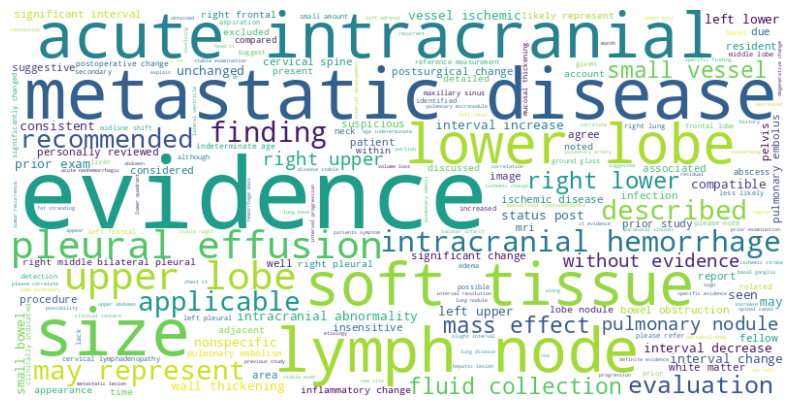

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text columns into a single string
all_text = ' '.join(CT_report_pre['impression'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Entity Extraction

In [88]:
%%capture
import sys
#!{sys.executable} -m pip install spacy

#!{sys.executable} -m pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [92]:
!{sys.executable} -m pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 88.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019105 sha256=2c4a26df08424da5d77fb74ff28d8f804ca602a1e4782e807bd3948bc753a762
  Stored in directory: /home/jupyter/.cache/pip/wheels/64/69/41/6f820cf1d7488a0381a2059f66ec9f8f23116f7c67d18f3d8d
Successfully built en-core-web-sm
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.5.0
ERROR: Cannot uninstall typing-extensions 4.5.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps typing-extensions==4.5.0'.


In [81]:
import spacy

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Perform named entity recognition (NER) on each text column
ner_findings = CT_report_pre['findings'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])
ner_background = CT_report_pre['background'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])
ner_impression = CT_report_pre['impression'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])

# Print named entities for each column
print("Named Entities - Findings:", ner_findings)
print("Named Entities - Background:", ner_background)
print("Named Entities - Impression:", ner_impression)

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.